In [1]:
import pandas as pd
from ast import literal_eval
from nltk.tokenize import sent_tokenize, word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
import spacy

# Load Datasets

We load the preprocessed datasets. Make sure to run the previous notebooks first, so the files are present.

## media articles

In [2]:
df_media = pd.read_csv('../data/cleantech-media.csv', converters={"token_content": literal_eval}, parse_dates=['date'])
df_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9588 entries, 0 to 9587
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          9588 non-null   object        
 1   date           9588 non-null   datetime64[ns]
 2   author         31 non-null     object        
 3   content        9588 non-null   object        
 4   domain         9588 non-null   object        
 5   url            9588 non-null   object        
 6   token_content  9588 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 524.5+ KB


In [3]:
df_media.head(5)

,title,date,author,content,domain,url,token_content
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,Qatar Petroleum ( QP) is targeting aggressive ...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[qatar, petroleum, qp, target, aggress, cut, g..."
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,Nuclear Power Corp. of India Ltd. ( NPCIL) syn...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[nuclear, power, corp, india, ltd, npcil, sync..."
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,New US President Joe Biden took office this we...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[new, us, presid, joe, biden, take, offic, wee..."
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,The slow pace of Japanese reactor restarts con...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[slow, pace, japanes, reactor, restart, contin..."
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,Two of New York City's largest pension funds s...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[two, new, york, citi, larg, pension, fund, sa..."


## patents

In [4]:
df_patents = pd.read_csv('../data/google_patents.csv', converters={"token_content": literal_eval}, parse_dates=['publication_date'])
df_patents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13199 entries, 0 to 13198
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   publication_number  13199 non-null  object        
 1   application_number  13199 non-null  object        
 2   country_code        13199 non-null  object        
 3   publication_date    13199 non-null  datetime64[ns]
 4   inventor            13199 non-null  object        
 5   title               13199 non-null  object        
 6   abstract            13199 non-null  object        
 7   abstract_lang       13199 non-null  object        
 8   token_content       13199 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 928.2+ KB


In [5]:
df_patents.head()

,publication_number,application_number,country_code,publication_date,inventor,title,abstract,abstract_lang,token_content
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,['en'],"[disclos, adapt, dc, ac, invert, system, oper,..."
1,US-2022239251-A1,US-202217580956-A,US,2022-07-28,[],System for providing the energy from a single ...,"In accordance with an example embodiment, a so...",['en'],"[accord, exampl, embodi, solar, energi, system..."
2,US-11396827-B2,US-202117606042-A,US,2022-07-26,[],Control method for optimizing solar-to-power e...,A control method for optimizing a solar-to-pow...,['en'],"[control, method, optim, solar, power, effici,..."
3,CN-114772674-A,CN-202210500131-A,CN,2022-07-22,[],Low-carbon running saline wastewater treatment...,The invention discloses a system and a method ...,"['zh', 'en']","[invent, disclos, system, method, treat, low, ..."
4,CN-217026795-U,CN-202220668705-U,CN,2022-07-22,[],Water ecological remediation device convenient...,The utility model discloses a water ecological...,"['zh', 'en']","[util, model, disclos, water, ecolog, restor, ..."


# Modeling with BERTopic

## Preprocessing

With BERTopic it is advised to work with the raw texts: "removing stop words as a preprocessing step is not advised as the transformer-based embedding models that we use need the full context in order to create accurate embeddings." (<https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html>). Therefore we use the slightly cleaned, but original content- and abstract-column.

The same document also advises to split up long documents - that's our first step:

### Split up large chunks of text

In [6]:
text_corpus_media = df_media.content

sentences_media = [sent_tokenize(doc) for doc in text_corpus_media]
sentences_media = [sentence for doc in sentences_media for sentence in doc]

sentences_media[0:3]

['Qatar Petroleum ( QP) is targeting aggressive cuts in its greenhouse gas emissions as it prepares to launch Phase 2 of its planned 48 million ton per year LNG expansion.',
 "In its latest Sustainability Report published on Wednesday, QP said its goals include `` reducing the emissions intensity of Qatar's LNG facilities by 25% and of its upstream facilities by at least 15%. ''",
 'The company is also aiming to reduce gas flaring intensity across its upstream facilities by more than 75% and has raised its carbon capture and storage ambitions from 5 million tons/yr to 7 million tons/yr by 2027.']

In [7]:
len(sentences_media)

331630

In [8]:
text_corpus_patents = df_patents.abstract

sentences_patents = [sent_tokenize(doc) for doc in text_corpus_patents]
sentences_patents = [sentence for doc in sentences_patents for sentence in doc]

sentences_patents[0:3]

['Disclosed is an adaptable DC-AC inverter system and its operation.',
 'The system includes multiple DC input sources as input to provide a stable operation under various conditions.',
 'DC input sources may be added to the system or removed from the system without impacting the functionality of the system.']

In [9]:
len(sentences_patents)

28748

### Limit training samples

Depending on where you run this you might want to reduce training samples.

In [10]:
# Limit samples to constant MAX_SAMPLES
MAX_SAMPLES = 10_000

training_sentences_media = sentences_media[0:MAX_SAMPLES]
training_sentences_patents = sentences_patents[0:MAX_SAMPLES]

In [11]:
(len(training_sentences_media), len(training_sentences_patents))

(10000, 10000)

### Calculate Embeddings

Embeddings are the numerical representation of our text data, which are needed as an input to our model.

We pre-calculate the embeddings to feed them into BERT. This saves us time later when optimising our model, as we do not have to recalculate this step every time.

In [12]:
embedding_model_media = SentenceTransformer("all-MiniLM-L6-v2")

embeddings_media = embedding_model_media.encode(training_sentences_media, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [13]:
embeddings_media.shape

(10000, 384)

In [14]:
embedding_model_patents = SentenceTransformer("all-MiniLM-L6-v2")

embeddings_patents = embedding_model_patents.encode(training_sentences_patents, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [15]:
embeddings_patents.shape

(10000, 384)

### Dimensionality reduction (UMAP)

As seen above each document is represented in a 384-dimensional space. Per default BERTopic is using UMAP to reduce the dimensions, we use it here too. As UMAP introduces some randomness we initialise the model here and include a `random_state` in order to get reproducible results.

In [16]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

### Clustering (HDBSCAN)

We use a clustering algorithm to group similar texts together in order to find our topics. We use the default HDBSCAN with some custom parameters. Most important is probably `min_cluster_size` as it defines the minimum size of a cluster and therefore indirectly determines how many different topics there are (the lower the number, the more topics found in general).

In [17]:
hdbscan_model = HDBSCAN(min_cluster_size=75, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### Vectorizer

After clustering our documents into different topic groups, we can use the Vectorizer to steer how topics are represented. Here we introduce a CountVectorizer with english stop word removal, to make sure we have no stop words in our topic definitions, as they do not really tell something about any topic in general. With `min_df` we also make sure only words which occur at least twice are considered.

In [18]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2)

### Representation models

Topics can also be fine-tuned. Here we use two approaches:

In [19]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech

# KeyBERT
keybert_model = KeyBERTInspired()

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
}

## Train 

Let's finally train our models, for the media- and patent-dataset seperately.

In [20]:
topic_model_media = BERTopic(

  # Pipeline models
  embedding_model=embedding_model_media,
  umap_model=umap_model,
  vectorizer_model=vectorizer_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

topics_media, probs_media = topic_model_media.fit_transform(training_sentences_media, embeddings_media)

2024-04-28 21:49:37,895 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
/Users/pascal/1_code/master_ids/clt-cleantech-project/venv/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-04-28 21:49:59,512 - BERTopic - Dimensionality - Completed ✓
2024-04-28 21:49:59,513 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-28 21:49:59,936 - BERTopic - Cluster - Completed ✓
2024-04-28 21:49:59,939 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-28 21:50:06,032 - BERTopic - Representation - Completed ✓


In [21]:
topic_model_media.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,4274,-1_energy_gas_oil_said,"[energy, gas, oil, said, year, carbon, new, bi...","[renewables, fuels, renewable, demand, emissio...","[energy, gas, oil, said, year, carbon, new, bi...",[Capex Pertamina plans to allocate 9% or about...
1,0,1288,0_carbon_emissions_climate_capture,"[carbon, emissions, climate, capture, zero, co...","[emissions, carbon, co2, 2050, 2030, greenhous...","[carbon, emissions, climate, capture, zero, co...","[', ""Carbon capture capacity today stands at j..."
2,1,1213,1_wind_solar_energy_offshore,"[wind, solar, energy, offshore, power, renewab...","[renewables, renewable, turbines, offshore, wi...","[wind, solar, energy, offshore, power, renewab...",[We believe Scotland has the potential to buil...
3,2,899,2_said_think_need_companies,"[said, think, need, companies, supply, market,...","[future, say, demand, economic, risk, investme...","[said, think, need, companies, supply, market,...","[Because that, I think, is where most of the f..."
4,3,615,3_nuclear_reactors_power_reactor,"[nuclear, reactors, power, reactor, energy, pl...","[nuclear, reactors, reactor, energy, 2050, 203...","[nuclear, reactors, power, reactor, energy, pl...",[But he also refocused his pro-nuclear argumen...
5,4,429,4_hydrogen_green_ammonia_blue,"[hydrogen, green, ammonia, blue, production, t...","[hydrogen, renewable, fuels, fuel, green, elec...","[hydrogen, green, ammonia, blue, production, t...",[The Neom plant is the world’ s largest commer...
6,5,335,5_lng_santos_barossa_gas,"[lng, santos, barossa, gas, million, year, dar...","[lng, lngi, santos, imports, supply, cargoes, ...","[lng, santos, barossa, gas, million, year, dar...","[', 'Gasunie said that new and existing LNG si..."
7,6,192,6_china_saudi_arabia_xi,"[china, saudi, arabia, xi, energy, beijing, ch...","[china, renewable, shanghai, beijing, guangdon...","[china, saudi, arabia, xi, energy, beijing, ch...","[', 'While many in the West question China’ s ..."
8,7,159,7_oil_gas_prices_demand,"[oil, gas, prices, demand, industry, said, glo...","[oil, petroleum, fuels, gasoline, markets, eco...","[oil, gas, prices, demand, industry, said, glo...","[Oil prices were rising ahead of winter, mostl..."
9,8,146,8_million_barrels_000_day,"[million, barrels, 000, day, oil, 11, output, ...","[refinery, opec, oil, barrels, 2021, forecast,...","[million, barrels, 000, day, oil, 11, output, ...","[About 93.6% of oil output was still off line,..."


In [22]:
topic_model_patents = BERTopic(

  # Pipeline models
  embedding_model=embedding_model_patents,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

topics_patents, probs_patents = topic_model_patents.fit_transform(training_sentences_patents, embeddings_patents)

2024-04-28 21:50:06,110 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-28 21:50:19,516 - BERTopic - Dimensionality - Completed ✓
2024-04-28 21:50:19,517 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-28 21:50:19,869 - BERTopic - Cluster - Completed ✓
2024-04-28 21:50:19,872 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-28 21:50:23,181 - BERTopic - Representation - Completed ✓


In [23]:
topic_model_patents.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,2577,-1_energy_solar_heat_power,"[energy, solar, heat, power, device, arranged,...","[solar, photovoltaic, energy, heating, cooling...","[energy, solar, heat, power, device, arranged,...",[The heat collecting plate comprises a support...
1,0,2526,0_solar_panel_lamp_photovoltaic,"[solar, panel, lamp, photovoltaic, energy, arr...","[photovoltaic, solar, lamp, panel, utility, li...","[solar, panel, lamp, photovoltaic, energy, arr...",[The invention relates to a frameless solar la...
2,1,2033,1_water_hydropower_plate_model,"[water, hydropower, plate, model, arranged, co...","[hydropower, hydroelectric, utility, pipeline,...","[water, hydropower, plate, model, arranged, co...",[The utility model relates to the technical fi...
3,2,723,2_heat_water_solar_heating,"[heat, water, solar, heating, energy, temperat...","[photovoltaic, solar, heating, heater, evapora...","[heat, water, solar, heating, energy, temperat...",[The invention belongs to the technical field ...
4,3,657,3_wind_power_energy_generation,"[wind, power, energy, generation, generator, b...","[generator, turbine, wind, photovoltaic, gener...","[wind, power, energy, generation, generator, b...",[The utility model belongs to the technical fi...
5,4,488,4_hydrogen_production_energy_gas,"[hydrogen, production, energy, gas, storage, f...","[hydrogen, hydrogenation, electrolysis, fuel, ...","[hydrogen, production, energy, gas, storage, f...",[The utility model belongs to the technical fi...
6,5,287,5_water_seawater_treatment_sewage,"[water, seawater, treatment, sewage, desalinat...","[desalination, photovoltaic, seawater, solar, ...","[water, seawater, treatment, sewage, desalinat...",[The invention provides a solar seawater desal...
7,6,193,6_geothermal_heat_pipe_exchange,"[geothermal, heat, pipe, exchange, energy, dee...","[geothermal, heating, heater, utility, heat, e...","[geothermal, heat, pipe, exchange, energy, dee...",[The embodiment of the application provides a ...
8,7,129,7_irrigation_water_device_spraying,"[irrigation, water, device, spraying, tank, pl...","[irrigation, photovoltaic, watering, solar, ut...","[irrigation, water, device, spraying, tank, pl...",[The utility model discloses a full-automatic ...
9,8,107,8_catalyst_photocatalyst_material_method,"[catalyst, photocatalyst, material, method, ca...","[photocatalytic, photocatalyst, photocatalysis...","[catalyst, photocatalyst, material, method, ca...",[The invention relates to the technical field ...


### first short conclusion

In the media dataset much of the topics are separated along geopolitical dimensions like large projects in certain countries/continents (e.g. Africa, China, Saudi-Arabia), sanctions due to the Russia-Ukraine war, etc. Also many topics are dominated by technologies or ressources which are clearly not considered "clean" like oil and gas. But as these are part of the motivation and maybe reasons for cleaner technologies they seem to appear hear as media is reporting in a broader societal/political context.

The patent dataset topics however are clearly focused on different technologies. We see hydropower, wind, geothermal, solar and so on. This also makes sense as they are focused on exactly describing the technology used and not so much on the motivation behind it. 

### Experimental: get topic names with local LLM

As an experiment (and to save money on OpenAi-tokens) we wrote an experimental function to fine-tune the topic with a local LLM. In order to work this requires a local running Ollama-instance. See here for details: <https://ollama.com/>

Here we use `llama2` to generate names for our topics analogously to the ChatGPT example in the [BERTopic-documentation](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html#openai).

In [24]:
import json
import requests

In [25]:
def get_ollama_topic(representative_docs, keywords, model='llama2'):

    # URL of the API
    url = "http://localhost:11434/api/generate"

    topic_prompt = f"""
    I have a topic that contains the following documents:
    {representative_docs}
    The topic is described by the following keywords: {keywords}
    
    Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
    topic: <topic label>
    """
    
    # Data to be sent
    data = {
        "model": model,
        "prompt": topic_prompt,
        "stream": False
    }
    
    # Send POST request with data
    response = requests.post(url, json=data)
    
    # Print response
    response_text = json.loads(response.text).get('response', None)
    
    return response_text.strip().replace('Topic: ', '').splitlines()[0]

In [26]:
# get topic names from LLM and prepare dict
topic_dict_media = {x['Topic']: get_ollama_topic(x['Representative_Docs'], x['Representation']) for x in topic_model_media.get_topic_info().to_dict(orient='records')}
topic_dict_media[-1] = 'Outlier Topic'
topic_dict_media

{-1: 'Outlier Topic',
 0: 'Carbon Capture and Emissions Reduction',
 1: 'Offshore Wind',
 2: 'Investment Ideas',
 3: 'Nuclear Power',
 4: 'Green Hydrogen Production',
 5: 'LNG Expansion',
 6: 'Chinese energy cooperation in Saudi Arabia',
 7: 'Oil Prices and Demand',
 8: 'Oil Production',
 9: 'Uganda oil project',
 10: 'Electric Vehicles',
 11: 'Shell-BP Drilling in Gulf Mexico',
 12: 'Russian Gas Imports'}

In [27]:
# get topic names from LLM and prepare dict
topic_dict_patents = {x['Topic']: get_ollama_topic(x['Representative_Docs'], x['Representation']) for x in topic_model_patents.get_topic_info().to_dict(orient='records')}
topic_dict_patents[-1] = 'Outlier Topic'
topic_dict_patents

{-1: 'Outlier Topic',
 0: 'Solar Lamp',
 1: 'Water Conservancy and Hydropower',
 2: 'Solar Heating System',
 3: 'Wind Power Generation',
 4: 'Hydrogen Energy Power Generation',
 5: 'Solar Seawater Desalination Device',
 6: 'Geothermal Energy Heating',
 7: 'Irrigation Device',
 8: 'Photocatalyst for Carbon Dioxide Emission Reduction',
 9: 'Solar Drying',
 10: 'Wind-Wave Power Generation',
 11: 'Air flow guidance'}

In [28]:
# update model
topic_model_media.set_topic_labels(topic_dict_media)
topic_model_patents.set_topic_labels(topic_dict_patents)

In [29]:
# see new topic names
topic_model_media.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,Representative_Docs
0,-1,4274,-1_energy_gas_oil_said,Outlier Topic,"[energy, gas, oil, said, year, carbon, new, bi...","[renewables, fuels, renewable, demand, emissio...","[energy, gas, oil, said, year, carbon, new, bi...",[Capex Pertamina plans to allocate 9% or about...
1,0,1288,0_carbon_emissions_climate_capture,Carbon Capture and Emissions Reduction,"[carbon, emissions, climate, capture, zero, co...","[emissions, carbon, co2, 2050, 2030, greenhous...","[carbon, emissions, climate, capture, zero, co...","[', ""Carbon capture capacity today stands at j..."
2,1,1213,1_wind_solar_energy_offshore,Offshore Wind,"[wind, solar, energy, offshore, power, renewab...","[renewables, renewable, turbines, offshore, wi...","[wind, solar, energy, offshore, power, renewab...",[We believe Scotland has the potential to buil...
3,2,899,2_said_think_need_companies,Investment Ideas,"[said, think, need, companies, supply, market,...","[future, say, demand, economic, risk, investme...","[said, think, need, companies, supply, market,...","[Because that, I think, is where most of the f..."
4,3,615,3_nuclear_reactors_power_reactor,Nuclear Power,"[nuclear, reactors, power, reactor, energy, pl...","[nuclear, reactors, reactor, energy, 2050, 203...","[nuclear, reactors, power, reactor, energy, pl...",[But he also refocused his pro-nuclear argumen...
5,4,429,4_hydrogen_green_ammonia_blue,Green Hydrogen Production,"[hydrogen, green, ammonia, blue, production, t...","[hydrogen, renewable, fuels, fuel, green, elec...","[hydrogen, green, ammonia, blue, production, t...",[The Neom plant is the world’ s largest commer...
6,5,335,5_lng_santos_barossa_gas,LNG Expansion,"[lng, santos, barossa, gas, million, year, dar...","[lng, lngi, santos, imports, supply, cargoes, ...","[lng, santos, barossa, gas, million, year, dar...","[', 'Gasunie said that new and existing LNG si..."
7,6,192,6_china_saudi_arabia_xi,Chinese energy cooperation in Saudi Arabia,"[china, saudi, arabia, xi, energy, beijing, ch...","[china, renewable, shanghai, beijing, guangdon...","[china, saudi, arabia, xi, energy, beijing, ch...","[', 'While many in the West question China’ s ..."
8,7,159,7_oil_gas_prices_demand,Oil Prices and Demand,"[oil, gas, prices, demand, industry, said, glo...","[oil, petroleum, fuels, gasoline, markets, eco...","[oil, gas, prices, demand, industry, said, glo...","[Oil prices were rising ahead of winter, mostl..."
9,8,146,8_million_barrels_000_day,Oil Production,"[million, barrels, 000, day, oil, 11, output, ...","[refinery, opec, oil, barrels, 2021, forecast,...","[million, barrels, 000, day, oil, 11, output, ...","[About 93.6% of oil output was still off line,..."


In [30]:
topic_model_patents.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,Representative_Docs
0,-1,2577,-1_energy_solar_heat_power,Outlier Topic,"[energy, solar, heat, power, device, arranged,...","[solar, photovoltaic, energy, heating, cooling...","[energy, solar, heat, power, device, arranged,...",[The heat collecting plate comprises a support...
1,0,2526,0_solar_panel_lamp_photovoltaic,Solar Lamp,"[solar, panel, lamp, photovoltaic, energy, arr...","[photovoltaic, solar, lamp, panel, utility, li...","[solar, panel, lamp, photovoltaic, energy, arr...",[The invention relates to a frameless solar la...
2,1,2033,1_water_hydropower_plate_model,Water Conservancy and Hydropower,"[water, hydropower, plate, model, arranged, co...","[hydropower, hydroelectric, utility, pipeline,...","[water, hydropower, plate, model, arranged, co...",[The utility model relates to the technical fi...
3,2,723,2_heat_water_solar_heating,Solar Heating System,"[heat, water, solar, heating, energy, temperat...","[photovoltaic, solar, heating, heater, evapora...","[heat, water, solar, heating, energy, temperat...",[The invention belongs to the technical field ...
4,3,657,3_wind_power_energy_generation,Wind Power Generation,"[wind, power, energy, generation, generator, b...","[generator, turbine, wind, photovoltaic, gener...","[wind, power, energy, generation, generator, b...",[The utility model belongs to the technical fi...
5,4,488,4_hydrogen_production_energy_gas,Hydrogen Energy Power Generation,"[hydrogen, production, energy, gas, storage, f...","[hydrogen, hydrogenation, electrolysis, fuel, ...","[hydrogen, production, energy, gas, storage, f...",[The utility model belongs to the technical fi...
6,5,287,5_water_seawater_treatment_sewage,Solar Seawater Desalination Device,"[water, seawater, treatment, sewage, desalinat...","[desalination, photovoltaic, seawater, solar, ...","[water, seawater, treatment, sewage, desalinat...",[The invention provides a solar seawater desal...
7,6,193,6_geothermal_heat_pipe_exchange,Geothermal Energy Heating,"[geothermal, heat, pipe, exchange, energy, dee...","[geothermal, heating, heater, utility, heat, e...","[geothermal, heat, pipe, exchange, energy, dee...",[The embodiment of the application provides a ...
8,7,129,7_irrigation_water_device_spraying,Irrigation Device,"[irrigation, water, device, spraying, tank, pl...","[irrigation, photovoltaic, watering, solar, ut...","[irrigation, water, device, spraying, tank, pl...",[The utility model discloses a full-automatic ...
9,8,107,8_catalyst_photocatalyst_material_method,Photocatalyst for Carbon Dioxide Emission Redu...,"[catalyst, photocatalyst, material, method, ca...","[photocatalytic, photocatalyst, photocatalysis...","[catalyst, photocatalyst, material, method, ca...",[The invention relates to the technical field ...


## Visualise the topics

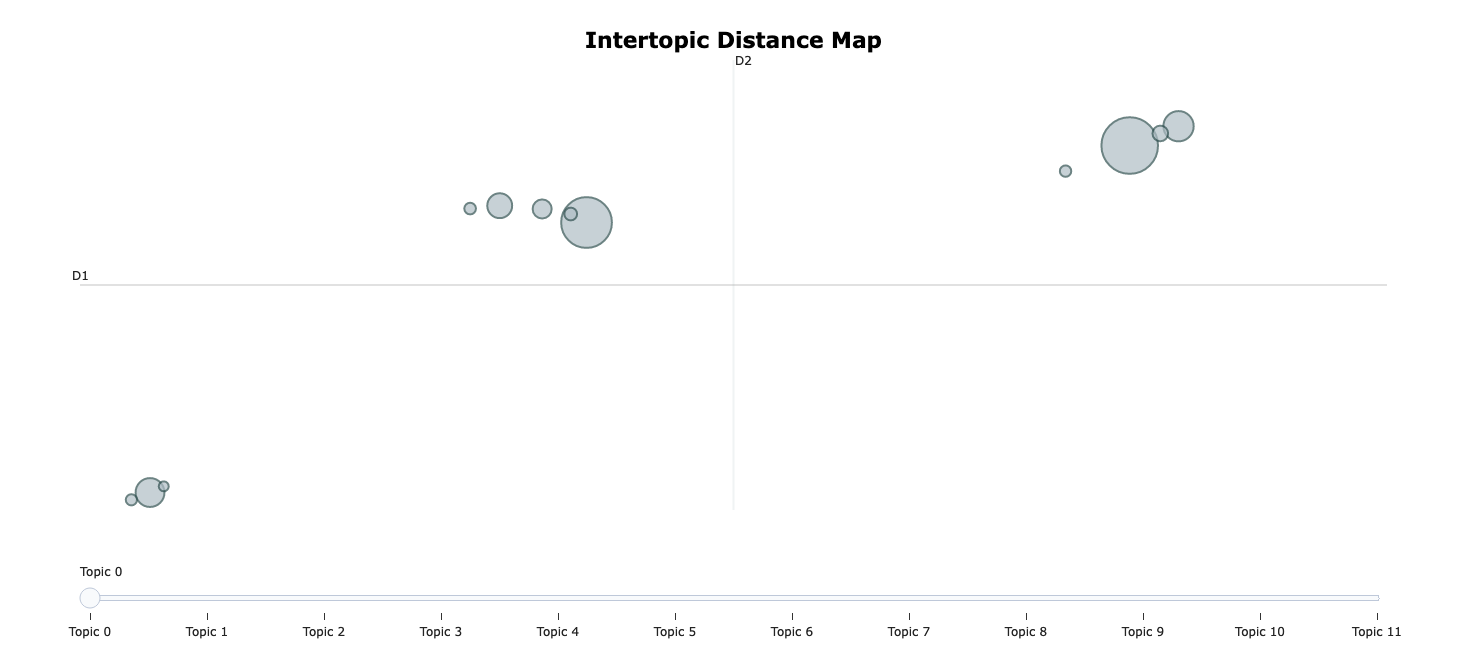

In [33]:
topic_model_patents.visualize_topics()

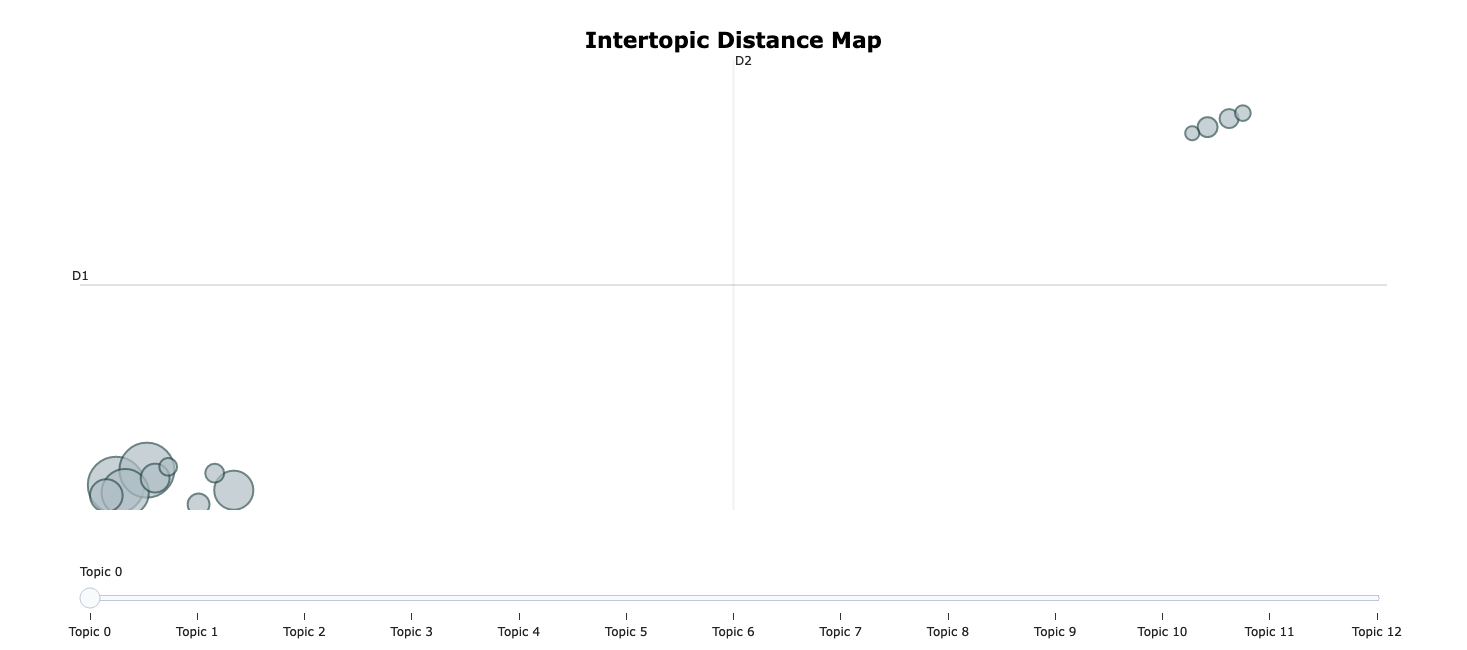

In [85]:
topic_model_media.visualize_topics()

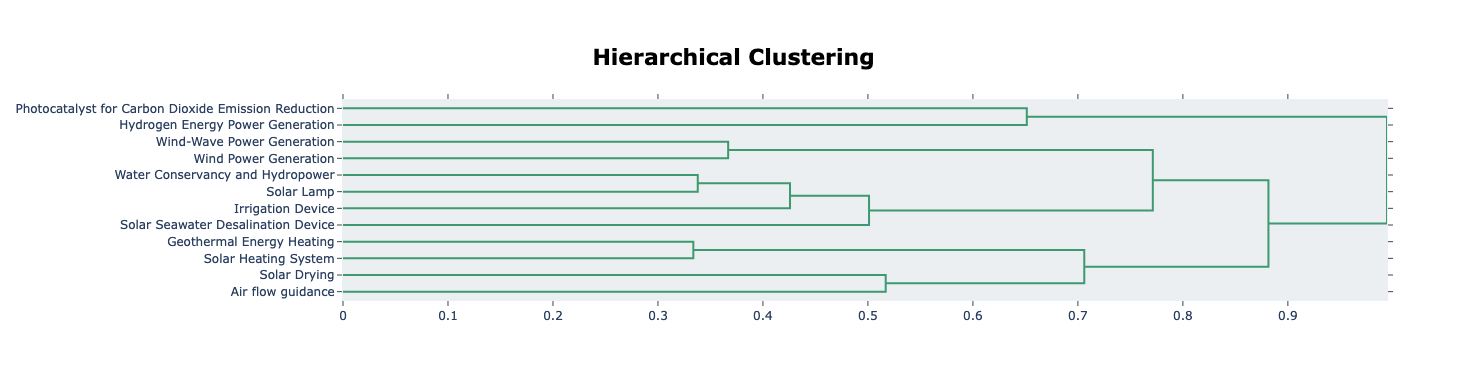

In [40]:
topic_model_patents.visualize_hierarchy(custom_labels=True)

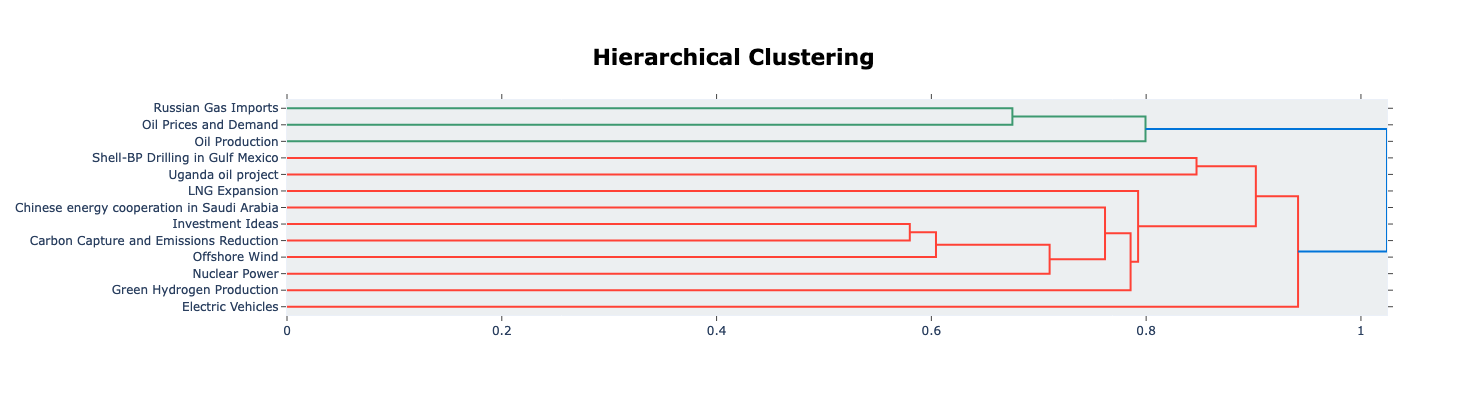

In [39]:
topic_model_media.visualize_hierarchy(custom_labels=True)

In [61]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model_media.approximate_distribution(training_sentences_media[2], use_embedding_model=True, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model_media.visualize_approximate_distribution(training_sentences_media[2], topic_token_distr[0])
df

  0%|                                                                                                                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


,The,company,is,also,aiming,to,reduce,gas,flaring,intensity,across,its,upstream,facilities,by,more,than,75,and,has,raised,its,carbon,capture,and,storage,ambitions,from,million,tons,yr,to,million,tons,yr,by,2027
0_carbon_emissions_climate_capture,0.249,0.612,0.812,1.137,1.364,1.293,1.260,0.935,0.459,0.362,0.562,0.927,1.345,1.427,1.059,0.695,0.277,0.000,0.142,0.584,1.045,1.577,1.941,1.879,1.777,1.551,1.321,1.202,1.183,1.050,1.080,1.124,1.043,1.186,0.880,0.575,0.316
1_wind_solar_energy_offshore,0.250,0.543,0.671,0.883,0.951,0.857,0.730,0.518,0.199,0.234,0.671,1.094,1.570,1.669,1.339,0.916,0.440,0.234,0.302,0.623,0.884,1.071,1.209,1.249,1.373,1.392,1.308,1.193,1.116,0.950,1.007,1.038,0.975,1.052,0.765,0.490,0.244
2_said_think_need_companies,0.415,0.933,1.236,1.498,1.287,0.902,0.599,0.336,0.133,0.100,0.420,0.709,1.085,1.369,1.202,1.017,0.819,0.602,0.723,0.870,0.866,0.935,0.791,1.020,1.364,1.546,1.733,1.413,1.167,0.937,0.855,0.921,0.857,0.952,0.718,0.492,0.285
3_nuclear_reactors_power_reactor,0.200,0.469,0.618,0.826,0.907,0.803,0.654,0.447,0.165,0.193,0.558,0.914,1.301,1.445,1.195,0.839,0.561,0.347,0.389,0.708,0.831,0.993,1.054,1.070,1.207,1.232,1.233,1.116,1.012,0.833,0.852,0.874,0.809,0.930,0.692,0.451,0.250
4_hydrogen_green_ammonia_blue,0.207,0.444,0.444,0.676,0.950,0.992,1.137,0.906,0.425,0.146,0.229,0.471,0.748,0.939,0.812,0.569,0.293,0.220,0.278,0.657,0.999,1.273,1.473,1.387,1.356,1.241,1.095,1.060,1.054,0.955,1.038,1.066,0.998,1.093,0.796,0.510,0.272
5_lng_santos_barossa_gas,0.249,0.608,0.812,1.060,1.120,0.945,0.741,0.493,0.185,0.189,0.634,1.073,1.532,1.615,1.287,0.960,0.501,0.367,0.378,0.534,0.762,0.916,1.054,1.113,1.237,1.286,1.298,1.315,1.355,1.290,1.384,1.396,1.318,1.384,1.014,0.658,0.342
6_china_saudi_arabia_xi,0.259,0.572,0.702,0.864,0.797,0.590,0.460,0.298,0.106,0.000,0.286,0.543,0.815,1.013,0.728,0.471,0.199,0.000,0.160,0.384,0.550,0.777,0.786,0.857,1.045,1.092,1.111,0.992,0.860,0.703,0.706,0.719,0.656,0.763,0.572,0.384,0.225
7_oil_gas_prices_demand,0.220,0.499,0.499,0.668,0.863,0.847,1.018,1.003,0.587,0.450,0.534,0.640,0.945,0.987,0.852,0.592,0.422,0.409,0.479,0.731,0.757,0.792,0.770,0.774,0.907,0.969,1.032,1.008,0.997,0.888,0.919,0.937,0.897,1.063,0.802,0.552,0.309
8_million_barrels_000_day,0.185,0.448,0.448,0.624,0.759,0.655,0.787,0.742,0.421,0.460,0.632,0.838,1.239,1.340,1.331,1.257,1.058,1.013,0.867,0.873,0.878,0.857,0.924,0.906,0.969,1.115,1.217,1.441,1.656,1.693,1.862,1.854,1.832,1.924,1.437,0.971,0.509
9_africa_uganda_tanzania_nigerian,0.373,0.784,1.016,1.229,1.096,0.805,0.573,0.360,0.120,0.188,0.639,1.124,1.580,1.742,1.291,0.806,0.350,0.000,0.166,0.417,0.600,0.844,0.839,0.867,1.031,1.093,1.241,1.182,1.113,1.020,0.944,0.963,0.908,0.940,0.707,0.468,0.246


In [64]:
len(topic_token_distr)

1

In [67]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_media)

In [71]:
df_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9588 entries, 0 to 9587
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          9588 non-null   object        
 1   date           9588 non-null   datetime64[ns]
 2   author         31 non-null     object        
 3   content        9588 non-null   object        
 4   domain         9588 non-null   object        
 5   url            9588 non-null   object        
 6   token_content  9588 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 524.5+ KB


In [82]:
embeddings_media.shape

(10000, 384)

In [73]:
reduced_embeddings.shape

(10000, 2)

In [84]:
reduced_embeddings[0]

array([4.84844  , 6.6045146], dtype=float32)

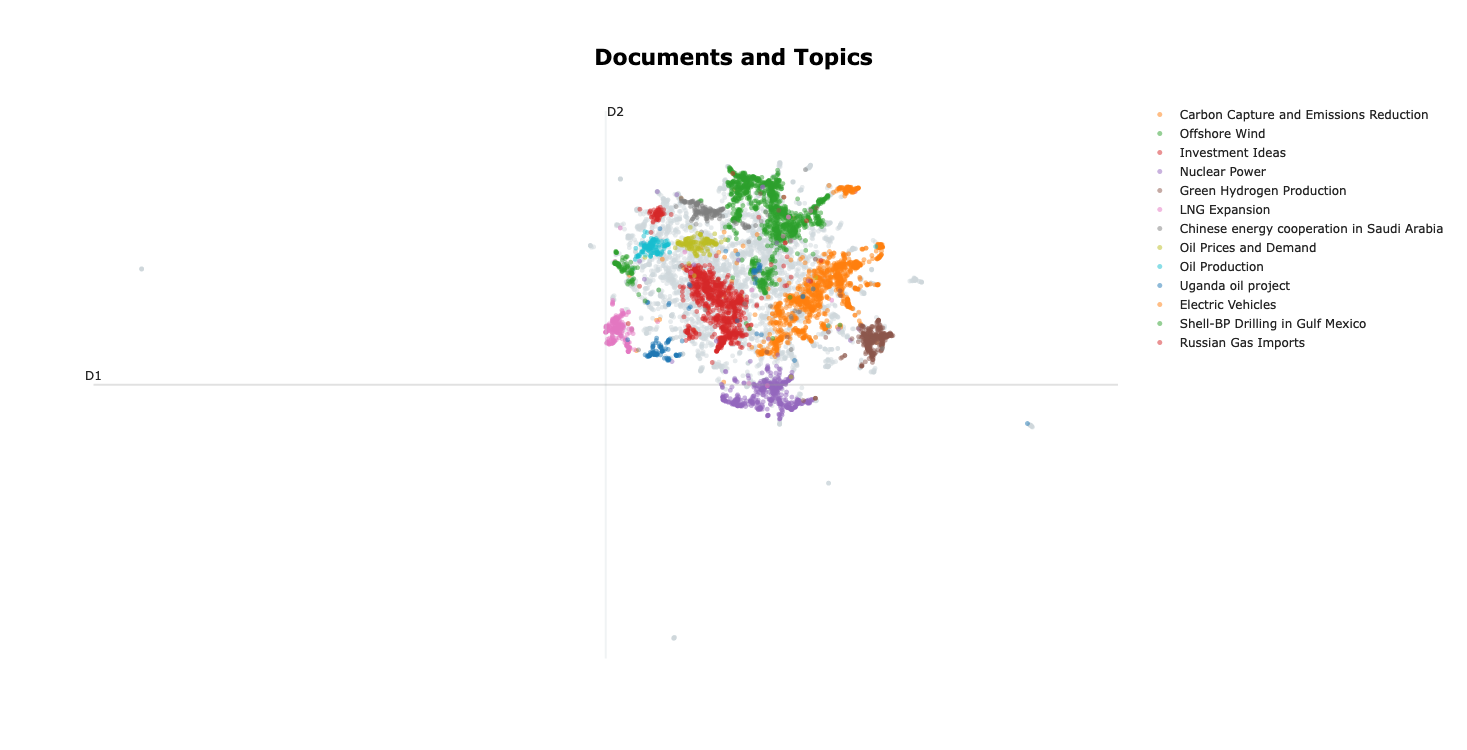

In [81]:
fake_titles = [str(sentences_media[i][:100]) for i  in range(0,10_000)]

topic_model_media.visualize_documents(fake_titles, reduced_embeddings=reduced_embeddings, custom_labels=True, hide_annotations=True)

In [79]:
len(fake_titles)

10000

In [78]:
fake_titles[0]

'1'